In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import pandas_profiling as ppf

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


test = pd.read_csv("dataset/test.csv")
train = pd.read_csv("dataset/train.csv")

### EDA

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
profile = ppf.ProfileReport(train)
profile.to_file(output_file="output.html")

### Data Preprocessing
#### Missing Values and Drop Unnecessary Cols
`Age` has 19.9% missing value, use mean to fill in the missing value.


In [2]:
train['Age'] = train.Age.fillna(np.mean(train.Age))
test['Age'] = test.Age.fillna(np.mean(test.Age))
train['Fare'] = train.Fare.fillna(np.mean(train.Fare))
test['Fare'] = test.Fare.fillna(np.mean(test.Fare))
train.drop(['Name','Cabin','Ticket','Embarked'],axis = 1, inplace = True)
test.drop(['Name','Cabin','Ticket','Embarked'],axis = 1, inplace = True)

In [4]:
test.Fare.isnull().sum() # double check how many missing values

0

#### Encode `gender` variable
`gender` is categorical variable and we want to convert it into numerical data.

In [3]:
lab = LabelEncoder()
train.Sex = lab.fit_transform(train.Sex)
test.Sex = lab.fit_transform(test.Sex)

#### Normalize Some of the Variables
Nornalize `Age`, `Fare`  by MinMaxScaler

In [4]:
minmax = MinMaxScaler()
train.Age = minmax.fit_transform(np.array(train.Age).reshape(-1,1))
test.Age = minmax.fit_transform(np.array(test.Age).reshape(-1,1))
train.Fare = minmax.fit_transform(np.array(train.Fare).reshape(-1,1))
test.Fare = minmax.fit_transform(np.array(test.Fare).reshape(-1,1))

In [5]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,0.452723,0,0,0.015282
1,893,3,0,0.617566,1,0,0.013663
2,894,2,1,0.815377,0,0,0.018909
3,895,3,1,0.353818,0,0,0.016908
4,896,3,0,0.287881,1,1,0.023984


In [6]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,0.271174,1,0,0.014151
1,2,1,1,0,0.472229,1,0,0.139136
2,3,1,3,0,0.321438,0,0,0.015469
3,4,1,1,0,0.434531,1,0,0.103644
4,5,0,3,1,0.434531,0,0,0.015713


In [7]:
x = train.drop('Survived',axis = 1)
y = train.Survived

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 0)

In [9]:
x_train.shape, y_train.shape

((623, 7), (623,))

### Model
Use 
1. logistic regression
2. Decision tree

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [11]:
logr = LogisticRegression()
logr.fit(x_train,y_train)

clf_tree = DecisionTreeClassifier()
clf_tree.fit(x_train,y_train)

print('logistic train score:',logr.score(x_train,y_train))
print('logistic test score:',logr.score(x_test,y_test))

print('desicion tree train score:',clf_tree.score(x_train,y_train)) 
print('decision tree test score:',clf_tree.score(x_test,y_test))



logistic train score: 0.8057784911717496
logistic test score: 0.7910447761194029
desicion tree train score: 1.0
decision tree test score: 0.753731343283582


Optimize the tree model by using `max_depth`.  
By the output in the last cell, it has overfitting problem. One way to deal with decision tree overfitting problem is to do pruning. But `sklearn` doesn't support for post pruning, here I use `max_depth` to decide the depth for the tree, therefore to avoid the overfitting in some way.

In [12]:
def clf_tree(d=None):
    clf_tree = DecisionTreeClassifier(max_depth=d)
    clf_tree.fit(x_train,y_train)
    return (clf_tree.score(x_train,y_train),clf_tree.score(x_test,y_test))


In [20]:
depths = np.arange(1,10)
scores = [clf_tree(d) for d in  depths]
test_score = [s[1] for s in scores]
train_score = [s[0] for s in scores]

# find out the index for the best scores for each part of the dataset
train_best_in = np.argmax(train_score)
test_best_in = np.argmax(test_score)

print('Best test index: ', test_best_in+1, 'best depth score: ', test_score[test_best_in])
print('Best train index: ', train_best_in+1, 'best depth score: ', train_score[train_best_in])

Best test index:  3 best depth score:  0.8208955223880597
Best train index:  9 best depth score:  0.9309791332263242


Till now the model has improved a lot in terms of the overfitting.  
Now visualize the results and validate the if the result returned in the last cell is the best depth in this case.

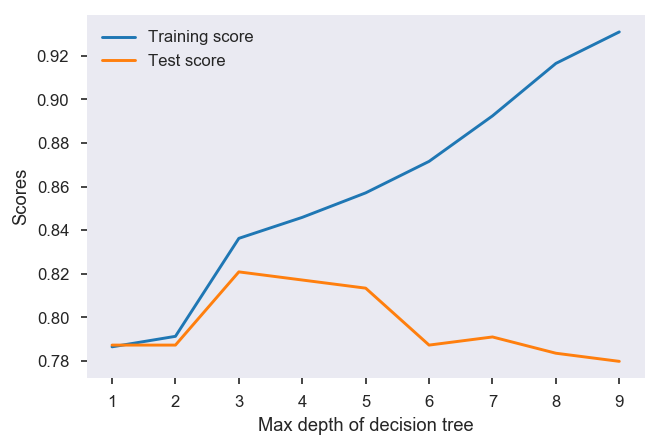

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(6,4),dpi=120) # dpi trannsparency
plt.xlabel('Max depth of decision tree')
plt.ylabel('Scores')
plt.plot(depths,train_score,label = 'Training score')
plt.plot(depths,test_score,label = 'Test score')
plt.legend()
plt.grid()

Now use `min_impurity_decrease` to do pruning on the tree and to optimize the model.  This parameter is used to define the threshold of the info entrophy or gini, when the info gain is lower than this threshold, then the tree stop splitting.

In [25]:
def min_split_score(val):
    clf = DecisionTreeClassifier(criterion='gini',min_impurity_decrease = val)
    clf.fit(x_train,y_train)
    return(clf.score(x_train,y_train),clf.score(x_test,y_test))

In [26]:
vals = np.linspace(0,0.2,100) # from 0 -0.2, divide by 100 
scores = [min_split_score(v) for v in vals ]
train_score = [s[0] for s in scores]
test_score = [s[1] for s in scores]

In [27]:
best_min_in = np.argmax(test_score)
bestscore = test_score[best_min_in]
print('bestmin value is:',vals[best_min_in],'best score is :',bestscore)

bestmin value is: 0.006060606060606061 best score is : 0.8246268656716418


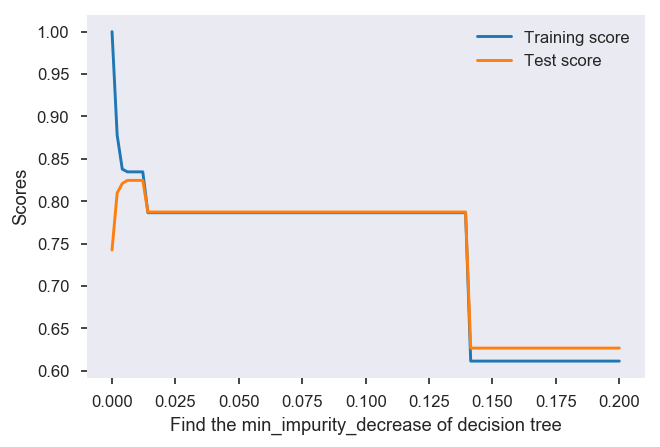

In [28]:
plt.figure(figsize=(6,4),dpi=120) # dpi trannsparency
plt.xlabel('Find the min_impurity_decrease of decision tree')
plt.ylabel('Scores')
plt.plot(vals,train_score,label = 'Training score')
plt.plot(vals,test_score,label = 'Test score')
plt.legend()
plt.grid()

At this point I have found two best parameters for the Decision Tree model, now use them to evaluate the model's performance.


In [30]:
from sklearn import metrics
model = DecisionTreeClassifier(max_depth=6,min_impurity_decrease = 0.006)
model.fit(x_train,y_train)
print('tree_score:',model.score(x_test,y_test))
y_pred = model.predict(x_test)

print('recall:',metrics.recall_score(y_test,y_pred))
print('precision:',metrics.precision_score(y_test,y_pred))
print('f1_score:',metrics.f1_score(y_test,y_pred))

tree_score: 0.8246268656716418
recall: 0.75
precision: 0.7731958762886598
f1_score: 0.7614213197969544


Use `GridSearch` to find the optimized params


In [33]:
from sklearn.model_selection import GridSearchCV
thresholds = np.linspace(0,0.2,50)
param_grid = {'min_impurity_decrease':thresholds,'max_depth':np.arange(1,10)}
clf= GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5)
clf.fit(x,y)

print('best params:{0}\nbest_score:{1}'.format(clf.best_params_,clf.best_score_))

best params:{'max_depth': 4, 'min_impurity_decrease': 0.00816326530612245}
best_score:0.8170594837261503


In [22]:
def plot_curve(train_sizes,cv_result,x_label):
    train_scores_mean=cv_result['mean_train_score']
    train_scores_std=cv_result['std_train_score']
    test_scores_mean=cv_result['mean_test_score']
    test_scores_std=cv_result['std_test_score']
    
    plt.figure(figsize=(10,6),dpi=120)
    plt.title('params tuning')
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes,train_score_mean - train_score_std,train_score_mean + train_score_std,alpha = 0.1,color='r')
    plt.fill_between(train_sizes,test_score_mean - test_score_std,test_score_mean + test_score_std,alpha = 0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'.--',color='g',label='training score')
    

In [34]:
mae = mean_absolute_error(y_pred,y_test)
mae

0.17537313432835822

In [23]:
prediction = logr.predict(test)
prediction

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [24]:
submission = pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':prediction})
submission.to_csv('submission_1.csv',index = False)

In [25]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
